We perform an l-1 regression analysis with feature vectors as miRNA expressions and targets as pathologic stage mapped to numbers 1 to 9

In [1]:
import os
import pandas

mirna_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/mirna/"
clinical_src_dir = os.getcwd() + "/assn-mirna-luad/data/processed/clinical/"

mirna_df = pandas.read_csv(mirna_src_dir+'mirna.csv')
clinical_df = pandas.read_csv(clinical_src_dir+'clinical.csv')

"""
Here we select samples to use for our regression analyss
"""
matched_samples = pandas.merge(clinical_df, mirna_df, on='patient_barcode').dropna(subset=['pathologic_stage', 'hsa-mir-96'])['patient_barcode']
print "matched_samples", matched_samples.shape
# merged = pandas.merge(clinical_df, mirna_df, on='patient_barcode')
# 
# print merged['histological_type'].value_counts().sort_index(axis=0)
# print merged['pathologic_stage'].value_counts().sort_index(axis=0)
# print merged['pathologic_T'].value_counts()
# print merged['pathologic_N'].value_counts()
# print merged['pathologic_M'].value_counts()

matched_samples (505,)


Do a simple miRNA feature selection with target values as the pathologic stage mapped to number range 1-9

In [2]:
pathologic_stage_map = {'Stage I': 1, 'Stage IA': 2, 'Stage IB': 3, 'Stage II': 4, 
                        'Stage IIA': 5, 'Stage IIB': 6, 'Stage IIIA': 7, 'Stage IIIB': 8, 'Stage IV': 9}
clinical_df.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

Prepare training & testing data

In [20]:
from sklearn import preprocessing

X = mirna_df[mirna_df['patient_barcode'].isin(matched_samples)]
X.__delitem__('patient_barcode')
Y = clinical_df[clinical_df['patient_barcode'].isin(matched_samples)]['pathologic_stage']
print 'miRNA null values', X.isnull().sum().sum()
print 'X.shape', X.shape
print 'Y.shape', Y.shape
mirna_list = X.columns.values

X = preprocessing.scale(X)
# Y = preprocessing.scale(Y)
Y = Y - 5 # Zero mean the target

miRNA null values 0
X.shape (505, 1881)
Y.shape (505,)


Perform LASSO feature selection with cross-validation to find best model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print 'X_train.shape', X_train.shape
print 'X_test.shape', X_test.shape

model = linear_model.LassoCV(cv=5, fit_intercept=True, n_jobs=-1)
print model.fit(X_train, y_train)

print "\nMSE train:", mean_squared_error(y_train, model.predict(X=X_train))
print "MSE test:", mean_squared_error(y_test, model.predict(X=X_test))

print "\nNon-zero coef:", np.nonzero(model.coef_)[0].size
print mirna_list[np.nonzero(model.coef_)[0]]
print model.coef_[np.nonzero(model.coef_)[0]]
# plt.hist(model.coef_, bins=100)
# plt.show()

X_train.shape (404, 1881)
X_test.shape (101, 1881)


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

MSE train: 4.01898699766
MSE test: 5.71700540128

Non-zero coef: 31
['hsa-mir-1205' 'hsa-mir-124-2' 'hsa-mir-129-2' 'hsa-mir-187'
 'hsa-mir-3197' 'hsa-mir-3609' 'hsa-mir-3646' 'hsa-mir-3934' 'hsa-mir-4310'
 'hsa-mir-4427' 'hsa-mir-4437' 'hsa-mir-4441' 'hsa-mir-4446' 'hsa-mir-4484'
 'hsa-mir-4497' 'hsa-mir-4518' 'hsa-mir-4644' 'hsa-mir-4678' 'hsa-mir-4738'
 'hsa-mir-4784' 'hsa-mir-548al' 'hsa-mir-548ar' 'hsa-mir-548o-2'
 'hsa-mir-548x-2' 'hsa-mir-5687' 'hsa-mir-5696' 'hsa-mir-6732'
 'hsa-mir-6811' 'hsa-mir-6876' 'hsa-mir-890' 'hsa-mir-892a']
[ 0.02340264  0.04695176  0.09489053 -0.00763823 -0.02717752  0.02598409
  0.03253039 -0.00587972 -0.0076338   0.09114295  0.00097944  0.03818567
 -0.01981177  0.02691396  0.04282849  0.03540159 -0.00969589 -0.0

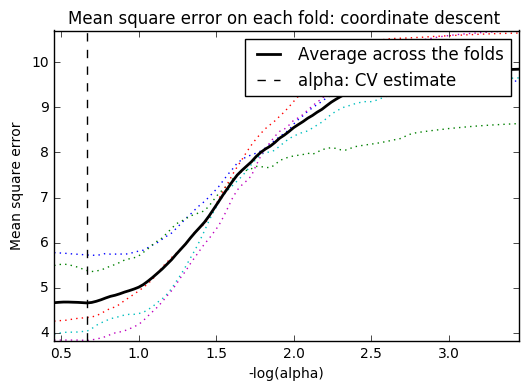

In [23]:
from matplotlib import pyplot as plt
# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

In [31]:
plt.hist(y_train - model.predict(X=X_train), bins=100)

plt.show()